In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sequence_jacobian import simple, create_model
from sequence_jacobian.utilities.drawdag import drawdag
from fredapi import Fred
import statsmodels.api as sm

np.random.seed(12345)

# Question 1

### Part 1

In [2]:
fred = Fred(api_key = 'f6fa4f544be19c2ea791e9a3240470bf')
start_date = '1947-01-01'

In [ ]:
## TO DO: create function to return logged data series

In [3]:
## SERIES UP TO 2019Q4
end_date = '2019-10-01'

Y_trunc = fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)
Y_log_trunc = np.log(fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)) * 100

# deflator for consumption series
defl_trunc = fred.get_series('PCECTPI', observation_start = start_date, observation_end = end_date)

# convert nominal consumption series to real
C_log_trunc = np.log(fred.get_series('PCEC', observation_start = start_date, observation_end = end_date) / defl_trunc) * 100
Cd_log_trunc = np.log(fred.get_series('PCDG', observation_start = start_date, observation_end = end_date) / defl_trunc) * 100
Cn_log_trunc = np.log(fred.get_series('PCND', observation_start = start_date, observation_end = end_date) / defl_trunc) * 100

I_log_trunc = np.log(fred.get_series('GPDIC1', observation_start = start_date, observation_end = end_date)) * 100
G_log_trunc = np.log(fred.get_series('GCEC1', observation_start = start_date, observation_end = end_date)) * 100

# total hours = weekly hours * employment
H_trunc = fred.get_series('PRS85006023', observation_start = start_date, observation_end = end_date)
E_trunc = fred.get_series('PAYEMS', observation_start = start_date, observation_end = end_date)
E_trunc = E_trunc[0:(len(E_trunc) + 1):3]
E_log_trunc = np.log(E_trunc) * 100
N_log_trunc = np.log(H_trunc * E_trunc) * 100

YN_log_trunc = np.log(Y_trunc / H_trunc) * 100

# convert nominal wages to real
w_log_trunc = np.log(fred.get_series('COMPNFB', observation_start = start_date, observation_end = end_date) / defl_trunc) * 100

# real interest rate = federal funds rate - realized inflation
ffr_trunc = fred.get_series('FEDFUNDS', observation_start = start_date, observation_end = end_date)
ffr_trunc = ffr_trunc[0:(len(ffr_trunc) + 1):3]
r_trunc = ffr_trunc - (np.diff(np.log(defl_trunc)) * 100)[29:]

In [4]:
## SERIES UP TO 2022Q4
end_date = '2022-10-01'

Y = fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)
Y_log = np.log(fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)) * 100

# deflator for consumption series
defl = fred.get_series('PCECTPI', observation_start = start_date, observation_end = end_date)

# convert nominal consumption series to real
C_log = np.log(fred.get_series('PCEC', observation_start = start_date, observation_end = end_date) / defl) * 100
Cd_log = np.log(fred.get_series('PCDG', observation_start = start_date, observation_end = end_date) / defl) * 100
Cn_log = np.log(fred.get_series('PCND', observation_start = start_date, observation_end = end_date) / defl) * 100

I_log = np.log(fred.get_series('GPDIC1', observation_start = start_date, observation_end = end_date)) * 100
G_log = np.log(fred.get_series('GCEC1', observation_start = start_date, observation_end = end_date)) * 100

# total hours = weekly hours * employment
H = fred.get_series('PRS85006023', observation_start = start_date, observation_end = end_date)
E = fred.get_series('PAYEMS', observation_start = start_date, observation_end = end_date)
E = E[0:(len(E) + 1):3]
E_log = np.log(E) * 100
N_log = np.log(H * E) * 100

YN_log = np.log(Y / H) * 100

# convert nominal wages to real
w_log = np.log(fred.get_series('COMPNFB', observation_start = start_date, observation_end = end_date) / defl) * 100

# real interest rate = federal funds rate - realized inflation
ffr = fred.get_series('FEDFUNDS', observation_start = start_date, observation_end = end_date)
ffr = ffr[0:(len(ffr) + 1):3]
r = ffr - (np.diff(np.log(defl)) * 100)[29:]

# Question 2

### Part 1

In [2]:
@simple
def firm(K, n, a, alpha, delta):    
    r = alpha * a * (K(-1) / n) ** (alpha-1) - delta
    w = (1 - alpha) * a * (K(-1) / n) ** alpha
    Y = a * K(-1) ** alpha * n ** (1 - alpha)
    return r, w, Y

@simple
def household(K, n, w, eis, frisch, b, delta):    
    C = (w / b / n ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, n, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * n
    
    capital_output_r = K/Y - 14.
    invest_output_r = I/Y - 0.25
    
    labor = n - 0.3333333
    
    return goods_mkt, euler, walras, capital_output_r, invest_output_r, labor

In [3]:
sigma = 0.01
eps = np.random.normal(0, sigma, 200)

In [4]:
rbc = create_model([household, firm, mkt_clearing], name="rbc_problem_input_a")

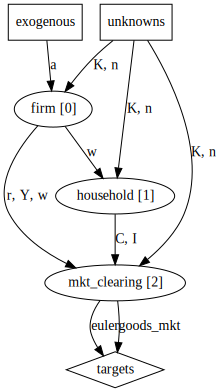

In [5]:
from sequence_jacobian import drawdag

unknowns = ["K", "n"]
targets = ["euler", "goods_mkt"]
inputs = ["a"]

drawdag(rbc, inputs, unknowns, targets)

In [6]:
# calibration: known parameter values
# unknowns: K, n, unknown paramenter values (b, beta, delta)
# targets: Euler equation, market-clearing condition, K/Y = 14, I/Y = 0.25, n = 1/3

calibration = {"eis": 0.5, "frisch": 1., "alpha": 0.33, "rho": 0.9, "a": 1.}
unknowns_ss = {"b": 0.9, "beta": 0.9,  "delta": 0.2, "K": 3., "n": 0.33}
targets_ss = {"goods_mkt": 0., "euler": 0., "capital_output_r": 0., "invest_output_r": 0., "labor": 0.}

ss = rbc.solve_steady_state(calibration, unknowns_ss, targets_ss, solver = "hybr")

In [7]:
for key, value in ss.items():
    print(key, value)

eis 0.5
frisch 1.0
alpha 0.33
rho 0.9
a 1.0
b 8.766078326227486
beta 0.9943181818181461
delta 0.017857142857142846
K 17.120544037004066
n 0.3333333
r 0.005714285714285731
w 2.4580212111148474
Y 1.2228960026431475
C 0.9171720019823605
I 0.30572400066078487
goods_mkt 2.1094237467877974e-15
euler 4.263256414560601e-14
walras 2.220446049250313e-16
capital_output_r 1.7763568394002505e-15
invest_output_r -1.6375789613221059e-15
labor 0.0


In [8]:
print(f"Goods market clearing: {ss['goods_mkt']},\nEuler equation: {ss['euler']},\nWalras: {ss['walras']}")

Goods market clearing: 2.1094237467877974e-15,
Euler equation: 4.263256414560601e-14,
Walras: 2.220446049250313e-16


In [9]:
PERIODS = 200
BURN = 50
T = PERIODS + BURN

In [10]:
unknowns = ['K', 'n']
targets = ['euler', 'goods_mkt']
inputs = ['a']

G = rbc.solve_jacobian(ss, unknowns, targets, inputs, T = T)

In [11]:
impact, rho = 0.01, 0.9
da = np.zeros((T, 2))
da[0, 0] = impact * ss['a']
da[:, 1] = impact * ss['a'] * rho**np.arange(T)

In [12]:
VAR_LIST = ["Y", "n", "C", "I", "K", "w", "r"]

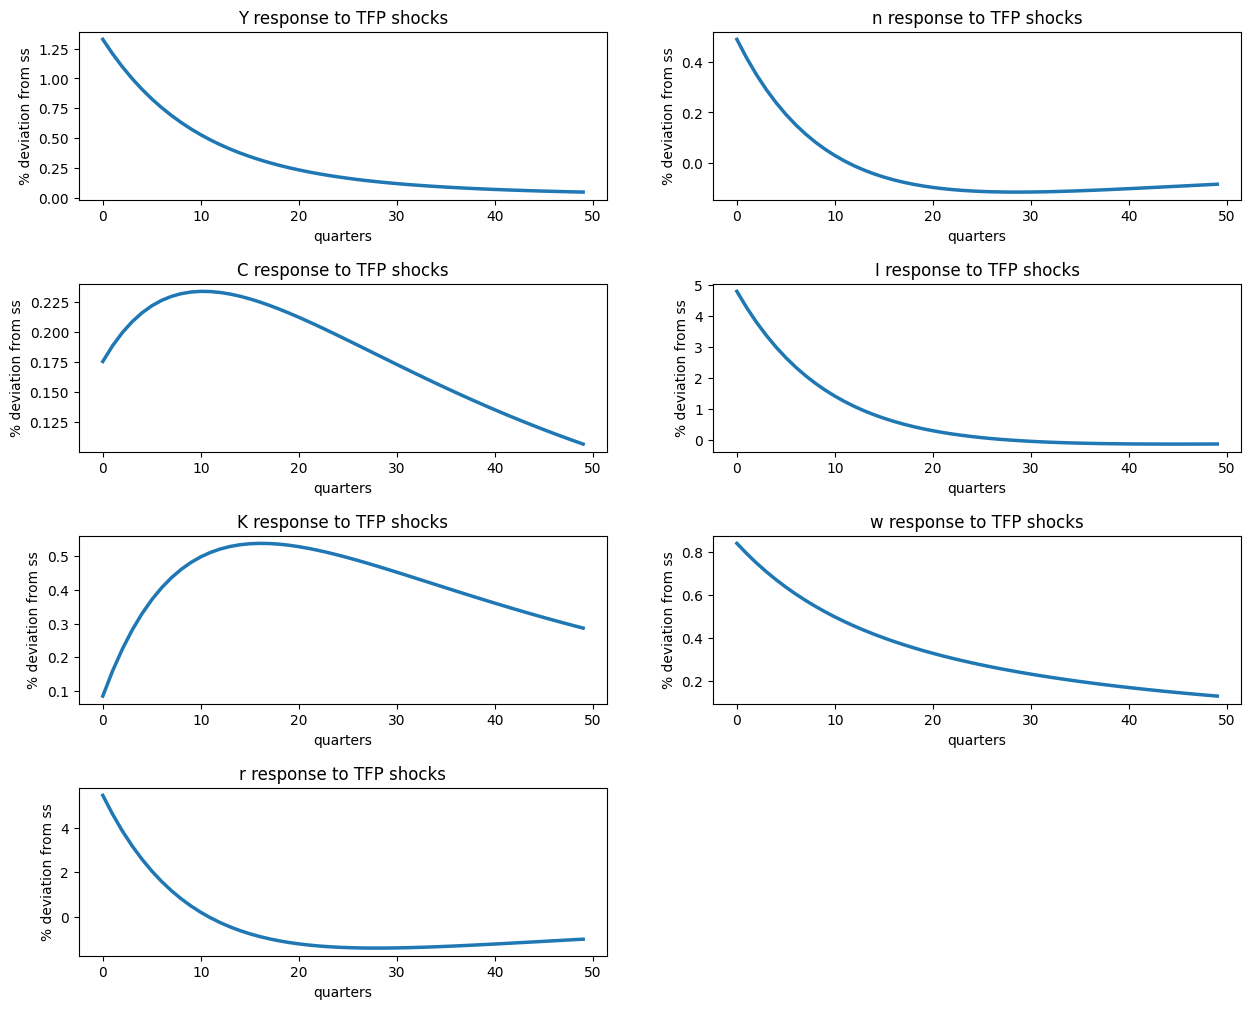

In [14]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)


for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G[var]['a'] @ da / ss[var]
    
    ax = plt.subplot(4, 2, i + 1)

    ax.plot(dVal[:50, 1], linewidth=2.5)
    ax.set_title(f'{var} response to TFP shocks')
    ax.set_ylabel('% deviation from ss')
    ax.set_xlabel('quarters')

plt.show()

### Part 2

First, let us construct a class to hold information about each simulation

In [15]:
import math
PERIODS = 200
BURN = 50
IMPACT = 0.01
RHO = 0.9

class Economy():
    def __init__(self, g_matrix, steady_state):
        # Get impulse response matrix and steady state from toolbox
        self.g_matrix = g_matrix 
        self.steady_state = steady_state

        # Create a list of iid shocks
        self.epsilon_list = np.random.normal(0, IMPACT, PERIODS + BURN)
        self.burned_epsilons = self.epsilon_list[BURN:]

        # Generate list of as given epsilons
        self.a_list = self.convert_epsilons_to_as(self.epsilon_list)
        self.burned_as = self.a_list[BURN:]

        # Generate a list of das given as deviations from steady state a
        self.da_list = [a - self.steady_state['a'] for a in self.a_list]
        self.burned_das = self.da_list[BURN:]

        # Generate sequences for capital, consumption, output, and labor
        self.sequences = {}
        for var in VAR_LIST:
            self.sequences[var] = self.simulate_sequence(var)

    def convert_epsilons_to_as(self, epsilon_list):
        """
        Given a sequence of iid normal shocks, generates an AR(1) process
        representing log of a. 
        """
        lna_list = np.zeros(PERIODS + BURN)
        lna_list[0] = self.steady_state['a']
        for i in range(1, PERIODS + BURN):
            lna_list[i] = lna_list[i-1] * RHO + epsilon_list[i]
        return [math.exp(lna) for lna in lna_list]
        
    def simulate_sequence(self, variable):
        """
        Given a variable, generates a sequence of values for that variable
        """
        
        sequence = []
        
        for t in range(PERIODS):
            past_shocks = self.burned_das[:t]
            past_response = np.flip(self.g_matrix[variable]['a'][1:t+1, 0]) @ past_shocks 
            
            logged_shock = np.log(self.burned_das[t] + self.steady_state['a']) - np.log(self.steady_state['a'])
            future_shocks = np.exp(np.ones(PERIODS + BURN) * logged_shock * rho ** np.arange(PERIODS + BURN))
            future_response = self.g_matrix[variable]['a'][0, :] @ future_shocks
            
            sequence.append(self.steady_state[variable] + past_response + future_response)

        return sequence
    
    # Now we do getters for the burned sequences
    def get_sequence(self, var):
        return self.sequences[var]
    
Economy(G, ss)

Now that we have our simulation class defined, we can generate 100 of them as desired

In [16]:
e = Economy(G, ss)

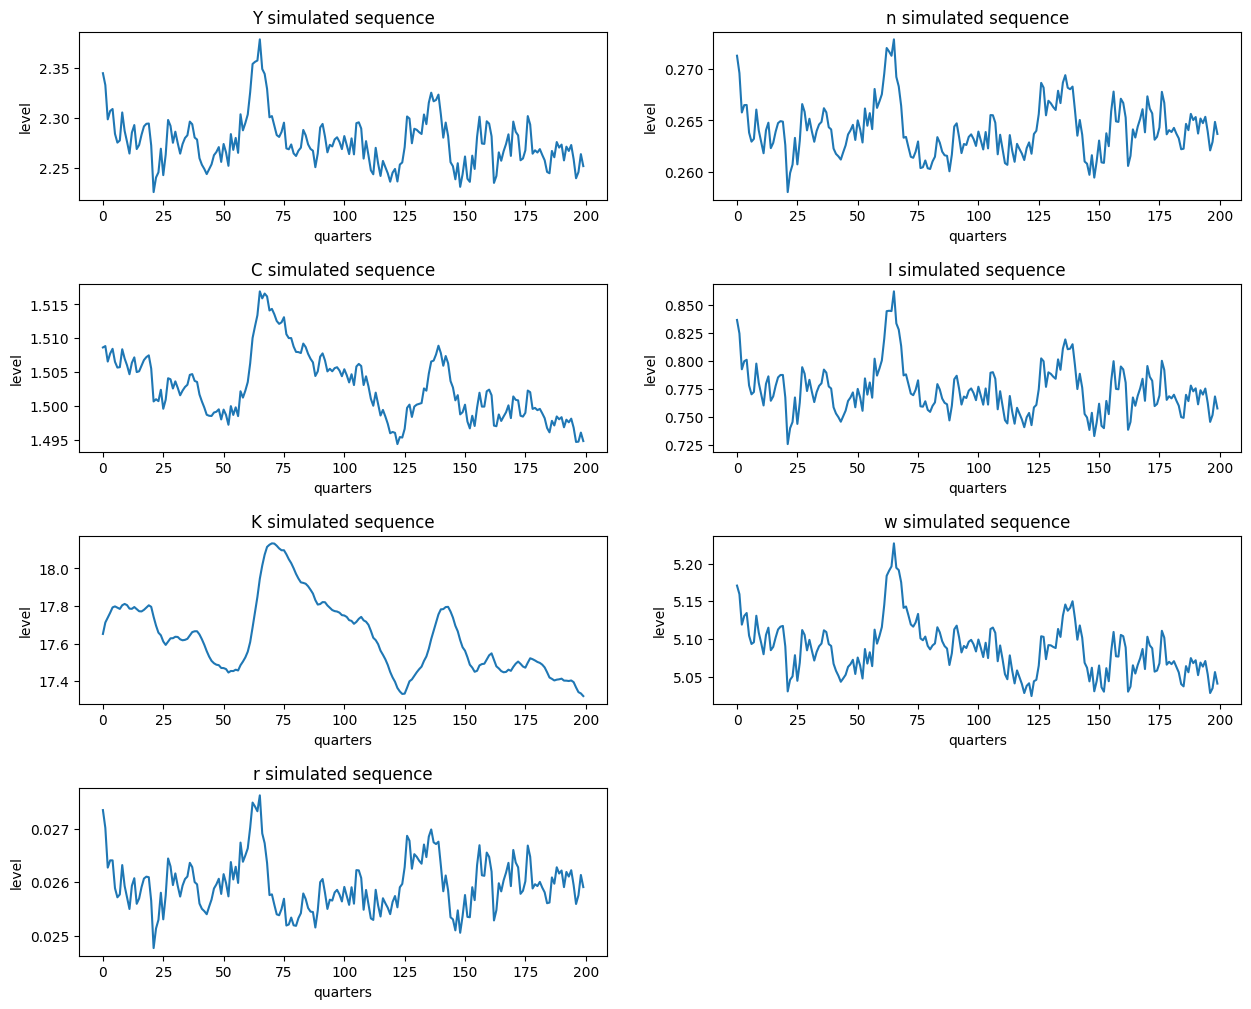

In [17]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G[var]['a'] @ da / ss[var]
    
    ax = plt.subplot(4, 2, i + 1)

    ax.plot(e.get_sequence(var))
    ax.set_title(f'{var} simulated sequence')
    ax.set_ylabel('level')
    ax.set_xlabel('quarters')
    
plt.show()

In [18]:
simulations = []
for i in range(100):
    e = Economy(G, ss)
    simulations.append(e)

## Parts 3 and 4

In [19]:
sample_simulation = simulations[0]

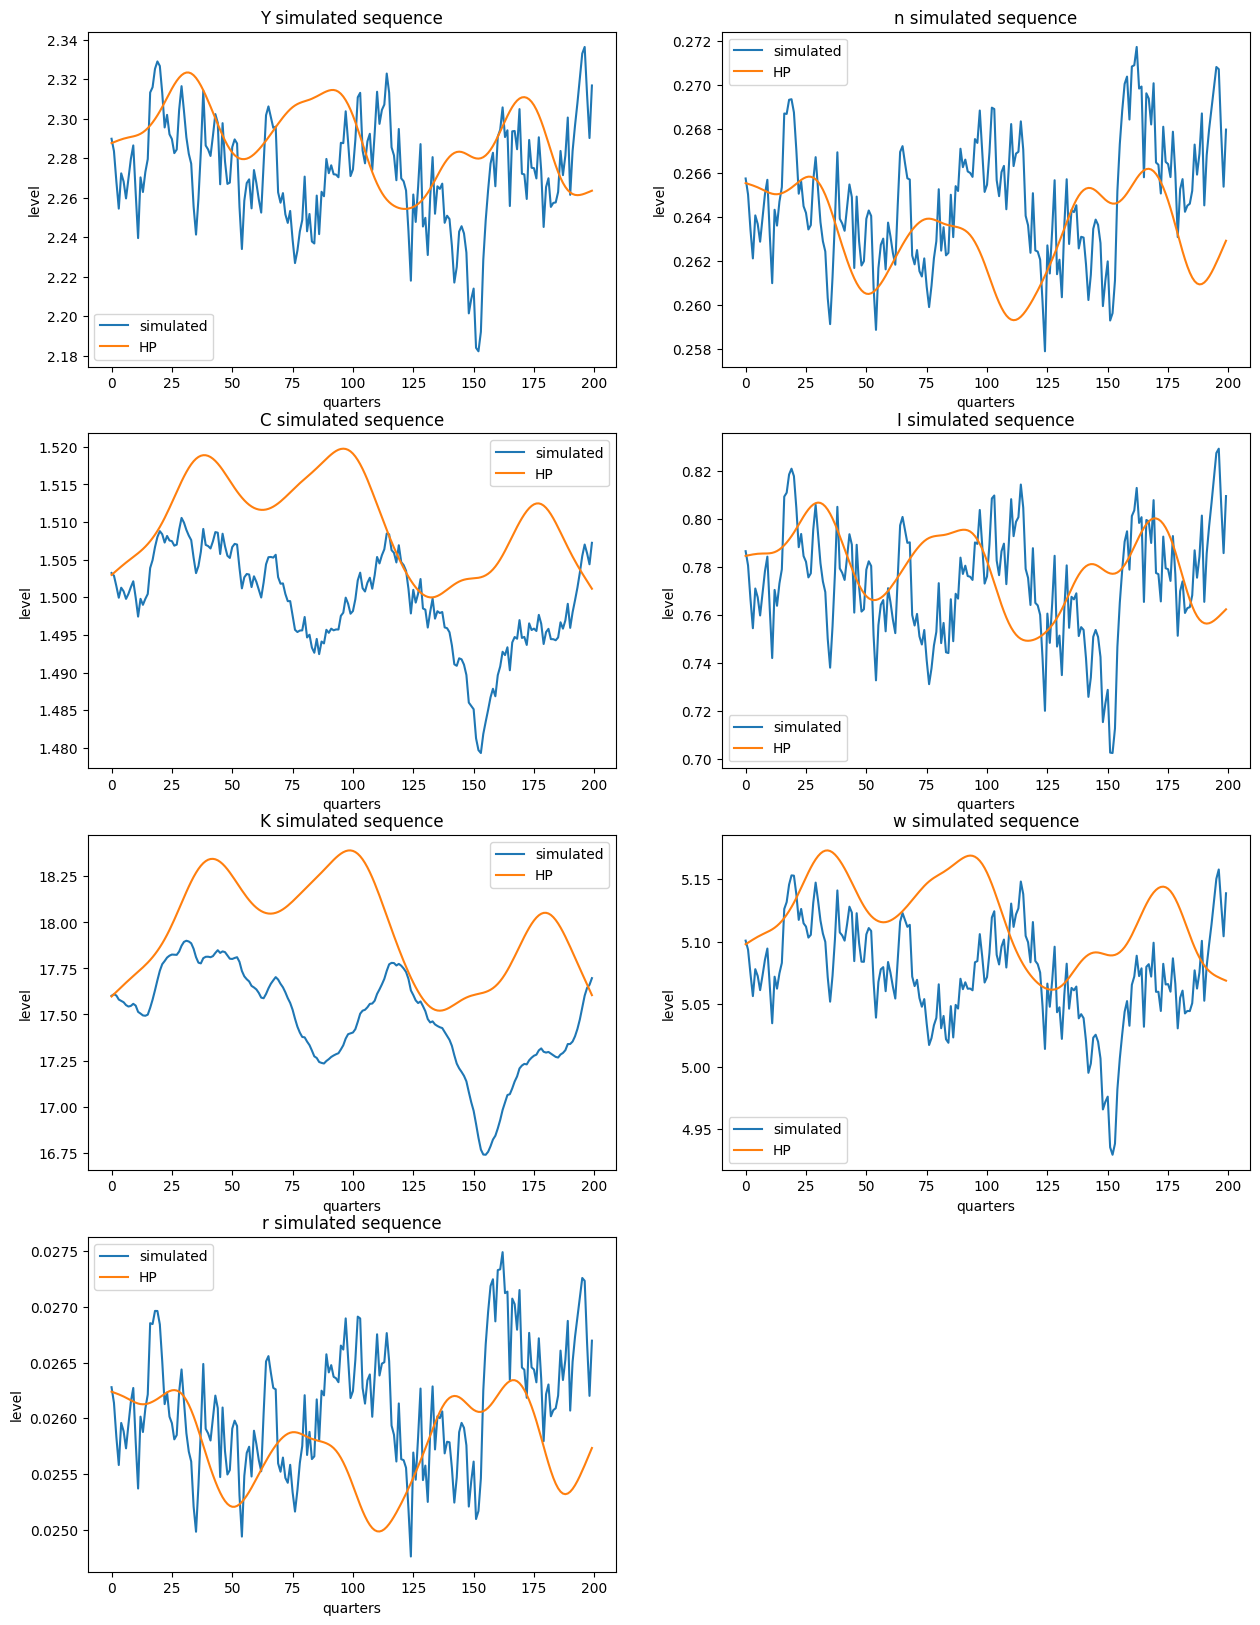

In [32]:
plt.figure(figsize=(15, 20))

for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]    
    ax = plt.subplot(4, 2, i+1)
    
    ax.plot(sample_simulation.get_sequence(var), label = "simulated")
    ax.plot(sm.tsa.filters.hpfilter(sample_simulation.get_sequence(var), 1600)[1], label = "HP")
    ax.set_title(f'{var} simulated sequence')
    ax.set_ylabel('level')
    ax.set_xlabel('quarters')
    ax.legend()
    
plt.show()

This looks like a standard RBC model of the business cycle -- all of the quantities are procyclic, as expected, but wages and interest rates which tend to be mostly uncorrelated with Y are strongly procyclic. PROBABLY SHOULD SAY MORE

## Part 5

In [79]:
sds = []
series_df = pd.DataFrame(list(zip([sample_simulation.get_sequence(var) for var in VAR_LIST])))

for i in range(len(VAR_LIST)):
    sds.append(np.std(sample_simulation.get_sequence(VAR_LIST[i])))
         
   

In [89]:
series_df = pd.DataFrame([sample_simulation.get_sequence(var) for var in VAR_LIST]).transpose()
series_df.columns = VAR_LIST
corr_df = series_df.corr()

In [90]:
corr_df

,Y,n,C,I,K,w,r
Y,1.000000,0.502303,0.758487,0.961292,0.615432,0.945672,0.438996
n,0.502303,1.000000,-0.182518,0.721109,-0.372406,0.193884,0.997423
C,0.758487,-0.182518,1.000000,0.549568,0.980450,0.929158,-0.252560
I,0.961292,0.721109,0.549568,1.000000,0.374440,0.819486,0.669564
K,0.615432,-0.372406,0.980450,0.374440,1.000000,0.838254,-0.438008
w,0.945672,0.193884,0.929158,0.819486,0.838254,1.000000,0.123029
r,0.438996,0.997423,-0.252560,0.669564,-0.438008,0.123029,1.000000


In [82]:
sds

[0.04485134096922052,
 0.004051643413076456,
 0.014791933036631873,
 0.03498607381877727,
 0.6452816285797683,
 0.07946079066140488,
 0.0008085660337697286]

## Part 6